# FDA Recall Classification Pipeline: Model Development and Evaluation
**By Lorena Dorado & Parisa Kamizi**

- This notebook implements modeling with multiple algorithms (Logistic Regression, Decision Tree, Random Forest, XGBoost, MLP).
- **Date:** April 22, 2025
- **Acknowledgment:** This notebook was improved with assistance from Claude (Anthropic), which helped with code optimization and analysis techniques.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.stats import randint, uniform, sem, t
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score,
    StratifiedShuffleSplit
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc,
    roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss
)
from sklearn.utils import resample
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter, defaultdict, OrderedDict

In [2]:
# Create directories for saving results and cached models
os.makedirs('results', exist_ok=True)
os.makedirs('results/baseline', exist_ok=True)
os.makedirs('results/hybrid', exist_ok=True)
os.makedirs('cache', exist_ok=True)

In [3]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
dataset_type = 'baseline'

# Load Data

In [4]:
# Load the dataset
train_path = f'../data/train_{dataset_type}.csv'
test_path = f'../data/test_{dataset_type}.csv'
try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print(f"Successfully loaded {dataset_type} datasets:")
    print(f"Training shape: {train_df.shape}")
    print(f"Testing shape: {test_df.shape}")
except FileNotFoundError:
    print(f"Error: {dataset_type} datasets not found. Please run Data Processing Notebook.ipynb")
    raise SystemExit("Aborting execution.")
else:
    # Basic dataset information
    print("\nTraining Dataset Overview:")
    print(f"Columns: {len(train_df.columns)}")
    
    # Target distribution
    target_col = 'Event Classification'
    target_dist = train_df[target_col].value_counts(normalize=True).reset_index()
    target_dist.columns = ['Class', 'Proportion']
    print("\nTarget Distribution:")
    print(target_dist)

Successfully loaded baseline datasets:
Training shape: (31492, 42)
Testing shape: (7874, 42)

Training Dataset Overview:
Columns: 42

Target Distribution:
       Class  Proportion
0   Class II    0.718246
1    Class I    0.212244
2  Class III    0.069510


## Data Cleaning (Validation)

In [5]:
# Check for missing values
missing = train_df.isnull().sum()
missing = missing[missing > 0]

print(f"Missing values in training data: {missing}" if not missing.empty else "No missing values in training data")

No missing values in training data


## Data Preparation

In [6]:
# Define features (X) and target (y)
X_train = train_df.drop(target_col, axis=1)
y_train = train_df[target_col]
X_test = test_df.drop(target_col, axis=1)
y_test = test_df[target_col]

In [7]:
# Check test data has the same columns as train data
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train.columns]

In [8]:
# Encode target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
class_names = le.classes_
print(f"Target Classes: {class_names}")
print(f"Encoded as: {np.unique(y_train_encoded)}")

Target Classes: ['Class I' 'Class II' 'Class III']
Encoded as: [0 1 2]


## Train-Test Split Validation

In [9]:
# Class distribution analysis
train_class_counts = pd.Series(y_train_encoded).value_counts()
test_class_counts = pd.Series(y_test_encoded).value_counts()
print("\nTraining class distribution (counts):")
print(train_class_counts)
print("\nTraining class distribution (percentages):")
print(pd.Series(y_train_encoded).value_counts(normalize=True) * 100)
print("\nTest class distribution (counts):")
print(test_class_counts)
print("\nTest class distribution (percentages):")
print(pd.Series(y_test_encoded).value_counts(normalize=True) * 100)


Training class distribution (counts):
1    22619
0     6684
2     2189
Name: count, dtype: int64

Training class distribution (percentages):
1    71.824590
0    21.224438
2     6.950972
Name: proportion, dtype: float64

Test class distribution (counts):
1    5655
0    1671
2     548
Name: count, dtype: int64

Test class distribution (percentages):
1    71.818644
0    21.221742
2     6.959614
Name: proportion, dtype: float64


In [10]:
# Display number of features
print(f"\nNumber of features: {X_train.shape[1]}")


Number of features: 41


In [11]:
# Display feature categories
temporal_features = [col for col in X_train.columns if any(x in col for x in ['Month', 'Day', 'Year', 'Week'])]
categorical_features = [col for col in X_train.columns if any(x in col for x in ['Type', 'Status', 'Region', 'DistScope'])]
flag_features = [col for col in X_train.columns if any(x in col for x in ['has_', 'allergen_', 'possible_'])]
print(f"Temporal features: {len(temporal_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"Flag features: {len(flag_features)}")
print(f"Other features: {X_train.shape[1] - len(temporal_features) - len(categorical_features) - len(flag_features)}")

Temporal features: 5
Categorical features: 16
Flag features: 19
Other features: 1


Pre-processed Dataset Validation: Checking infinity or NaN values

In [12]:
# Check for issues
inf_count = np.isinf(X_train.values).sum()
nan_count = np.isnan(X_train.values).sum()
if inf_count > 0 or nan_count > 0:
    print(f"Warning: Found {inf_count} infinity values and {nan_count} NaN values")
    # Handle issues
    X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
else:
    print("No infinity or NaN values found.")

No infinity or NaN values found.


# Modeling with Cross Validation

The models selected includ logistic regression (logreg), decision tree, random forest, xgboost, and multi-layer perceptron (mlp)

In [13]:
# Define models
models = {
    'logreg': {
        'model': LogisticRegression(solver='liblinear', max_iter=1000, random_state=42),
        'param_grid': {
            'model__C': [0.01, 0.1, 1, 10, 100],
            'model__penalty': ['l1', 'l2']
        },
        'needs_scaling': True,
        'feature_selector': SelectFromModel
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'param_grid': {
            'model__max_depth': [5, 10, 15, 20, None],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        },
        'needs_scaling': False,
        'feature_selector': SelectFromModel
    },
    'random_forest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, 20, None],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        },
        'needs_scaling': False,
        'feature_selector': SelectFromModel
    },
    'xgboost': {
        'model': XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', random_state=42),
        'param_grid': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 6],
            'model__subsample': [0.8, 1.0],
            'model__colsample_bytree': [0.8, 1.0]
        },
        'needs_scaling': False,
        'feature_selector': SelectFromModel
    },
    'mlp': {
        'model': MLPClassifier(max_iter=1000, random_state=42),
        'param_grid': {
            'model__hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'model__activation': ['relu', 'tanh'],
            'model__alpha': [0.0001, 0.001],
            'model__learning_rate': ['constant', 'adaptive']
        },
        'needs_scaling': True,
        'feature_selector': SelectKBest
    }
}

In [14]:
# Define number of features
n_features_options = [5, 10, 15, 20, 'all']  # 'all' = no feature selection

In [15]:
# Define number of cross-validation (CV) folds
n_cv_folds = 5

Stratified k-fold for consistent fold splitting

In [16]:
# Define skf
skf = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=42)

Store results

In [17]:
# Results Dictionary
results = defaultdict(list)
best_configs = {}

Track feature selection frequencies

In [18]:
# Create Dictionary
feature_importance = pd.DataFrame(0, index=X_train.columns, columns=list(models.keys()))

Iterate through each model

In [19]:
# Used ChatGPT to create this code that loops through a set of machine learning models
for model_name, model_config in models.items():
    print(f"\nTraining and evaluating {model_name}...")
    
    # Define cache path for this model
    model_cache_path = f'cache/{model_name}_{dataset_type}_results.joblib'
    
    if os.path.exists(model_cache_path):
        print(f"Loading cached {model_name} results...")
        model_results = joblib.load(model_cache_path)
        model_best_score = model_results['best_score']
        model_best_config = model_results['best_config']
        model_best_features = model_results.get('best_features', None)
    else:
        print(f"Training {model_name}...")
        
        model_best_score = 0
        model_best_config = None
        model_best_features = None
        
        # Iterate through different feature selection options
        for n_features in n_features_options:
            print(f"  Testing with feature selection: {n_features}")
            
            # Scores across folds
            fold_scores = []
            fold_feature_importances = []
            
            # Iterate through each fold
            for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train_encoded)):
                print(f"    Fold {fold_idx+1}/{n_cv_folds}")
                
                # Split data into training and validation sets for this fold
                X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_fold_train, y_fold_val = y_train_encoded[train_idx], y_train_encoded[val_idx]
                
                # Apply SMOTE only to the training portion of this fold
                sm = SMOTE(random_state=42)
                X_fold_train_resampled, y_fold_train_resampled = sm.fit_resample(X_fold_train, y_fold_train)
                
                # Define steps for the pipeline, conditionally including scaling
                steps = []
                
                # Add scaling if needed
                if model_config['needs_scaling']:
                    steps.append(('scaler', StandardScaler()))
                
                # Add feature selection unless n_features is 'all'
                if n_features != 'all':
                    if model_config['feature_selector'] == SelectKBest:
                        steps.append(('feature_selection', SelectKBest(f_classif, k=n_features)))
                    else:
                        steps.append(('feature_selection', model_config['feature_selector'](model_config['model'], max_features=n_features)))
                
                # Add the model
                steps.append(('model', model_config['model']))
                
                # Create pipeline
                pipeline = Pipeline(steps)
                
                # Create grid search for hyperparameter tuning
                grid_search = GridSearchCV(
                    pipeline,
                    param_grid=model_config['param_grid'],
                    cv=3,  # Use 3-fold CV for hyperparameter tuning within this fold
                    scoring='f1_weighted',
                    n_jobs=-1,
                    verbose=0
                )
                
                # Train with grid search
                grid_search.fit(X_fold_train_resampled, y_fold_train_resampled)
                
                # Get best model
                best_fold_model = grid_search.best_estimator_
                
                # Predict on validation fold
                y_fold_pred = best_fold_model.predict(X_fold_val)
                
                # Calculate F1 score
                fold_f1_score = f1_score(y_fold_val, y_fold_pred, average='weighted')
                fold_scores.append(fold_f1_score)
                
                # Track feature importance for this fold
                if n_features != 'all' and 'feature_selection' in best_fold_model.named_steps:
                    feature_selector = best_fold_model.named_steps['feature_selection']
                    if hasattr(feature_selector, 'get_support'):
                        support = feature_selector.get_support()
                        # Track which features were selected
                        selected_features = X_train.columns[support]
                        fold_feature_importances.append(selected_features)
                
                print(f"      Best params: {grid_search.best_params_}")
                print(f"      Validation F1 Score: {fold_f1_score:.4f}")
            
            # Calculate mean score across folds
            mean_score = np.mean(fold_scores)
            std_score = np.std(fold_scores)
            print(f"  Mean F1 Score for {n_features} features: {mean_score:.4f} (±{std_score:.4f})")
            
            # Store results
            results[model_name].append({
                'n_features': n_features,
                'mean_f1': mean_score,
                'std_f1': std_score,
                'fold_scores': fold_scores
            })
            
            # Update best configuration if this is better
            if mean_score > model_best_score:
                model_best_score = mean_score
                model_best_config = {
                    'n_features': n_features,
                    'parameters': grid_search.best_params_
                }
                
                # Track most frequently selected features
                if n_features != 'all' and fold_feature_importances:
                    # Count feature occurrences across folds
                    feature_counts = {}
                    for features in fold_feature_importances:
                        for feature in features:
                            if feature in feature_counts:
                                feature_counts[feature] += 1
                            else:
                                feature_counts[feature] = 1
                    
                    # Sort by frequency
                    sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
                    model_best_features = [f[0] for f in sorted_features[:n_features]]
                    
                    # Update feature importance tracking
                    for feature, count in feature_counts.items():
                        feature_importance.loc[feature, model_name] += count
        
        # Save results to cache after trying all feature options
        model_results = {
            'best_score': model_best_score,
            'best_config': model_best_config,
            'best_features': model_best_features
        }
        joblib.dump(model_results, model_cache_path)
    
    # Store the best configuration for this model
    best_configs[model_name] = {
        'config': model_best_config,
        'best_score': model_best_score,
        'best_features': model_best_features
    }
    
    print(f"\nBest configuration for {model_name}:")
    print(f"  Number of features: {model_best_config['n_features']}")
    print(f"  Best parameters: {model_best_config['parameters']}")
    print(f"  Best CV F1 Score: {model_best_score:.4f}")
    
    if model_best_features:
        print(f"  Most important features: {', '.join(model_best_features[:5])}")


Training and evaluating logreg...
Loading cached logreg results...

Best configuration for logreg:
  Number of features: all
  Best parameters: {'model__C': 0.1, 'model__penalty': 'l2'}
  Best CV F1 Score: 0.6894
  Most important features: ProductType_Devices, ProductType_Drugs, ProductType_Food/Cosmetics, ProductType_Veterinary, DistScope_Nationwide

Training and evaluating decision_tree...
Loading cached decision_tree results...

Best configuration for decision_tree:
  Number of features: all
  Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
  Best CV F1 Score: 0.8986
  Most important features: Month_sin, Month_cos, DayOfWeek_sin, DayOfWeek_cos, Years_Since_First

Training and evaluating random_forest...
Loading cached random_forest results...

Best configuration for random_forest:
  Number of features: all
  Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_esti

Normalize feature importance by number of folds

In [20]:
# Divide each feature count by number of CV folds
feature_importance = feature_importance / n_cv_folds

Find overall best model

In [21]:
# Find model with highest F1 score
best_model_name = max(best_configs, key=lambda k: best_configs[k]['best_score'])
best_model_score = best_configs[best_model_name]['best_score']
best_model_config = best_configs[best_model_name]['config']
best_model_features = best_configs[best_model_name]['best_features']

In [22]:
print(f"\nOverall best model: {best_model_name}")
print(f"Best CV F1 Score: {best_model_score:.4f}")
print(f"Best configuration: {best_model_config}")


Overall best model: random_forest
Best CV F1 Score: 0.9215
Best configuration: {'n_features': 'all', 'parameters': {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}}


Visualize model comparison

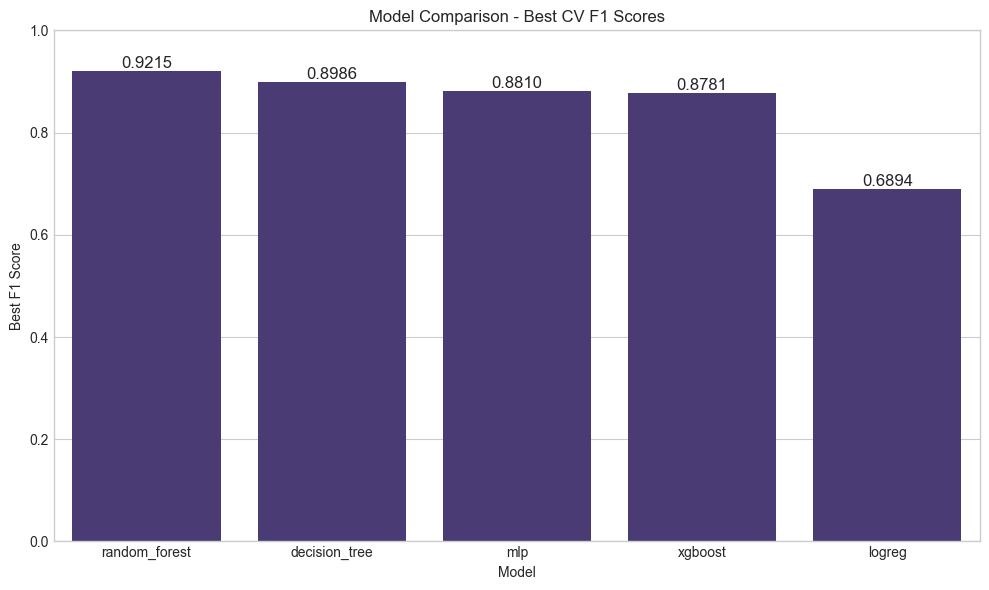

In [23]:
# Create dataframe of model and F1 scores to compare
model_comparison = pd.DataFrame([
    {'Model': model_name, 'Best F1 Score': config['best_score']}
    for model_name, config in best_configs.items()
])
model_comparison = model_comparison.sort_values('Best F1 Score', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Best F1 Score', data=model_comparison)
plt.title('Model Comparison - Best CV F1 Scores')
plt.ylim(0, 1.0)

# Add score labels
for i, p in enumerate(ax.patches):
    ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig(f'results/{dataset_type}/model_comparison_cv.png', dpi=300)
plt.show()
plt.close()

## Learning Curve Analysis for Random Forest

Observe model's performance changes with different training data sizes to determine if gathering more data would help

In [24]:
# Create a validation set for learning curve analysis
X_rf_train, X_rf_val, y_rf_train, y_rf_val = train_test_split(
    X_train.values, y_train_encoded, test_size=0.2, random_state=42, stratify=y_train_encoded
)

In [25]:
# Initialize the Random Forest model with best parameters from grid search
best_params = {k.replace('model__', ''): v for k, v in best_configs['random_forest']['config']['parameters'].items()}
model = RandomForestClassifier(**best_params, random_state=42)

In [26]:
# Define different training set sizes
train_sizes = np.linspace(0.1, 0.99, 10)
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

# Get total number of samples
n_total = X_rf_train.shape[0]

for frac in train_sizes:
    # Calculate number of samples for this fraction
    n_samples = int(n_total * frac)
    
    # Randomly select indices while preserving class distribution
    unique_classes = np.unique(y_rf_train)
    train_idx = []
    
    for cls in unique_classes:
        # Get indices of this class
        cls_indices = np.where(y_rf_train == cls)[0]
        # Sample the appropriate fraction
        n_cls_samples = int(len(cls_indices) * frac)
        # Randomly select indices
        sampled_indices = np.random.choice(cls_indices, size=n_cls_samples, replace=False)
        train_idx.extend(sampled_indices)
    
    # Create the subsampled dataset
    X_sub = X_rf_train[train_idx]
    y_sub = y_rf_train[train_idx]
    
    print(f"Training with {len(X_sub)} samples ({frac*100:.0f}% of training data)")
    
    # Fit model
    model.fit(X_sub, y_sub)
    
    # Predict probabilities and classes
    y_train_pred_proba = model.predict_proba(X_sub)
    y_val_pred_proba = model.predict_proba(X_rf_val)
    
    y_train_pred = model.predict(X_sub)
    y_val_pred = model.predict(X_rf_val)
    
    # Calculate log loss
    train_losses.append(log_loss(y_sub, y_train_pred_proba))
    val_losses.append(log_loss(y_rf_val, y_val_pred_proba))
    
    # Calculate F1 scores
    train_f1 = f1_score(y_sub, y_train_pred, average='weighted')
    val_f1 = f1_score(y_rf_val, y_val_pred, average='weighted')
    
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

Training with 2518 samples (10% of training data)
Training with 5009 samples (20% of training data)
Training with 7501 samples (30% of training data)
Training with 9991 samples (40% of training data)
Training with 12483 samples (50% of training data)
Training with 14974 samples (59% of training data)
Training with 17466 samples (69% of training data)
Training with 19958 samples (79% of training data)
Training with 22448 samples (89% of training data)
Training with 24940 samples (99% of training data)


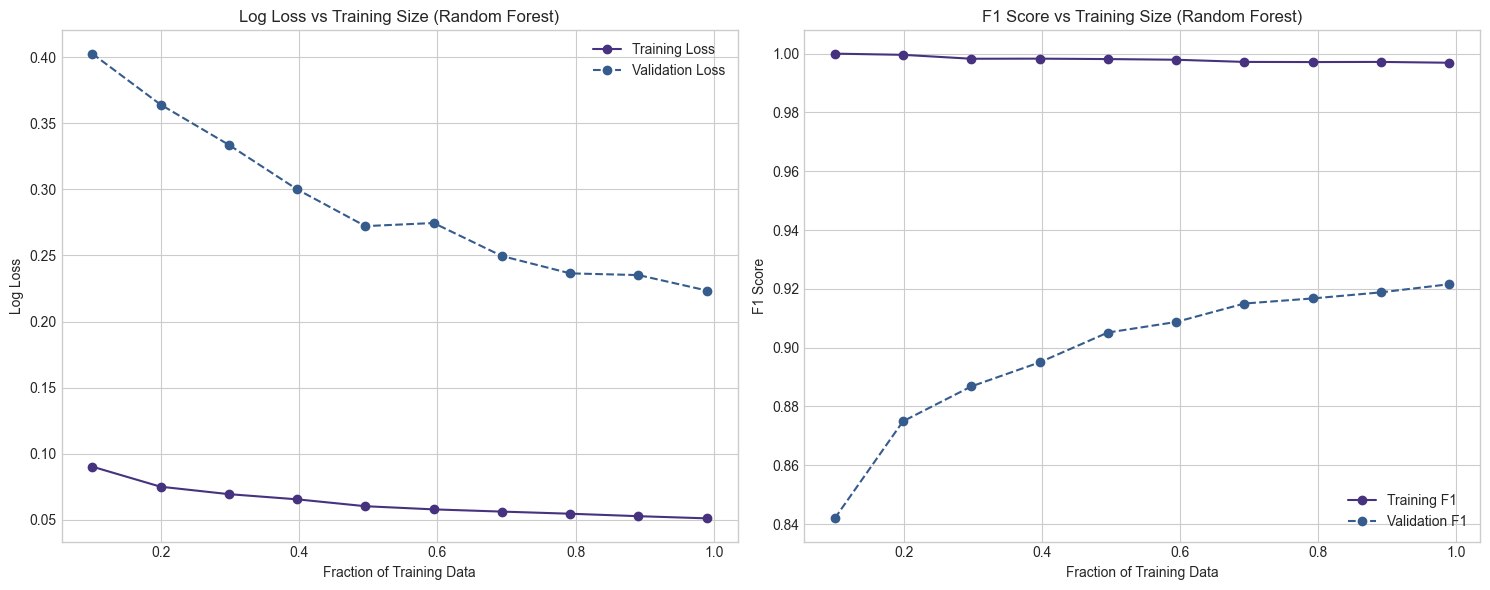

In [27]:
# Create figure with two subplots
plt.figure(figsize=(15, 6))

# Plot Log Loss
plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_losses, 'o-', label='Training Loss')
plt.plot(train_sizes, val_losses, 'o-', label='Validation Loss', linestyle='--')
plt.title('Log Loss vs Training Size (Random Forest)')
plt.xlabel('Fraction of Training Data')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)

# Plot F1 Score
plt.subplot(1, 2, 2)
plt.plot(train_sizes, train_f1_scores, 'o-', label='Training F1')
plt.plot(train_sizes, val_f1_scores, 'o-', label='Validation F1', linestyle='--')
plt.title('F1 Score vs Training Size (Random Forest)')
plt.xlabel('Fraction of Training Data')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(f'results/{dataset_type}/random_forest_learning_curve.png', dpi=300)
plt.show()
plt.close()

**Log Loss vs Training Size**
- Training Loss decreases as more data is used
- Validation Loss improves until around 40% of the data

**F1 Score vs Training Size**
- Training F1 shows the model fits the training data well
- Validation F1 shows improvement as more data is added

The gap between training and validation metrics show signs of overfitting. Both validation curves are still improving at 100%. Collecting more training examples would continue to improve model performance.

# Final Model Training and Evaluation

In [28]:
# Get best model configuration
best_config = best_configs[best_model_name]['config']
best_params = {k.replace('model__', ''): v for k, v in best_config['parameters'].items()}

## Train Final Model

Apply SMOTE to full training set

In [29]:
# Apply SMOTE to full training set
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train_encoded)

print(f"Final Model:{best_model_name}")

Final Model:random_forest


In [30]:
# Calculate class distribution before SMOTE
original_counter = Counter(y_train_encoded)
print("Class distribution before SMOTE:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {original_counter[i]} samples")

Class distribution before SMOTE:
Class I: 6684 samples
Class II: 22619 samples
Class III: 2189 samples


In [31]:
# Calculate class distribution after SMOTE
resampled_counter = Counter(y_train_resampled)
print("\nClass distribution after SMOTE:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {resampled_counter[i]} samples")


Class distribution after SMOTE:
Class I: 22619 samples
Class II: 22619 samples
Class III: 22619 samples


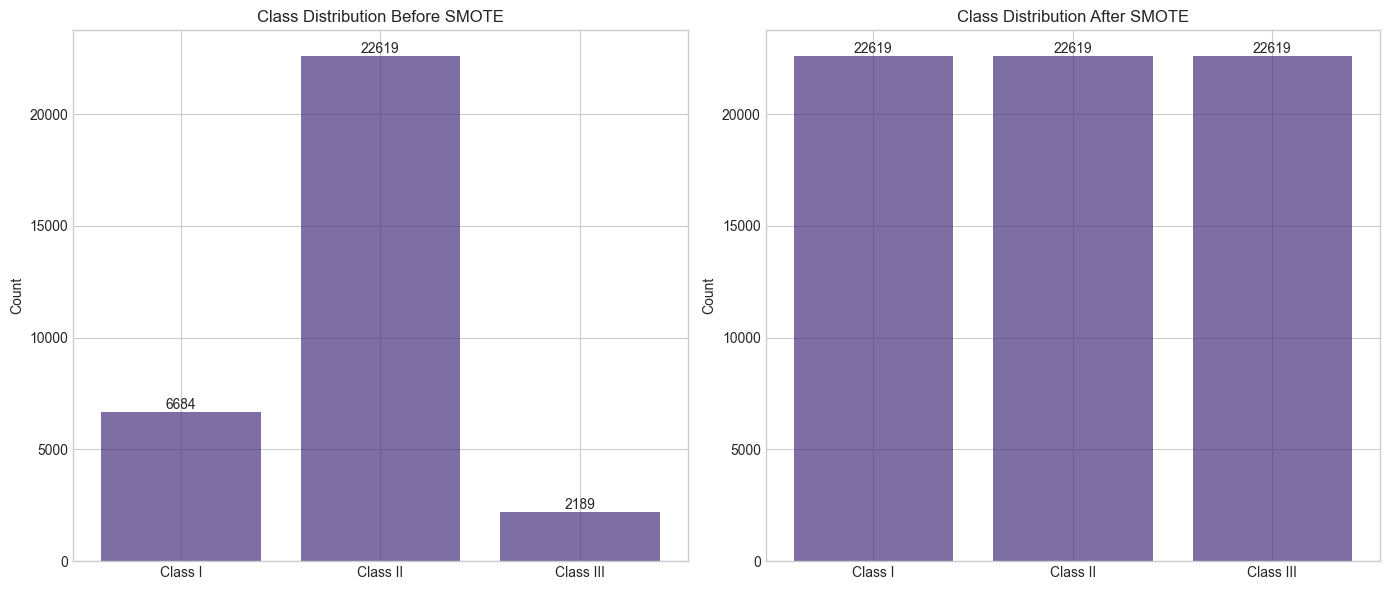

In [32]:
# Visualize the class distribution before and after SMOTE
plt.figure(figsize=(14, 6))

# Before SMOTE
plt.subplot(1, 2, 1)
before_counts = [original_counter[i] for i in range(len(class_names))]
bars = plt.bar(class_names, before_counts, alpha=0.7)
plt.title('Class Distribution Before SMOTE')
plt.ylabel('Count')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height}', ha='center', va='bottom')

# After SMOTE
plt.subplot(1, 2, 2)
after_counts = [resampled_counter[i] for i in range(len(class_names))]
bars = plt.bar(class_names, after_counts, alpha=0.7)
plt.title('Class Distribution After SMOTE')
plt.ylabel('Count')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f'results/{dataset_type}/smote_class_distribution.png', dpi=300)
plt.show()
plt.close()

In [33]:
# Calculate percentage increase for each class
percentage_changes = {}
for i, class_name in enumerate(class_names):
    original = original_counter[i]
    resampled = resampled_counter[i]
    pct_change = ((resampled - original) / original) * 100
    percentage_changes[class_name] = pct_change

print("\nPercentage changes in class sizes:")
for class_name, pct_change in percentage_changes.items():
    print(f"{class_name}: {pct_change:.2f}%")


Percentage changes in class sizes:
Class I: 238.41%
Class II: 0.00%
Class III: 933.30%


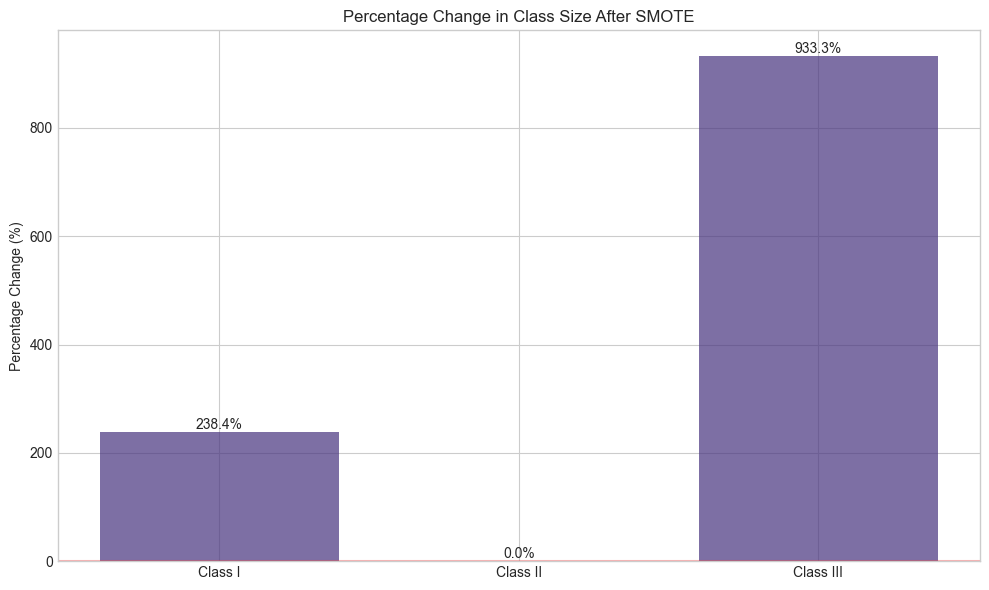

In [34]:
# Visualize the percentage changes
plt.figure(figsize=(10, 6))
plt.bar(percentage_changes.keys(), percentage_changes.values(), alpha=0.7)
plt.title('Percentage Change in Class Size After SMOTE')
plt.ylabel('Percentage Change (%)')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)

# Add value labels
for i, (class_name, pct_change) in enumerate(percentage_changes.items()):
    plt.text(i, pct_change + (5 if pct_change >= 0 else -20),
            f'{pct_change:.1f}%', ha='center')

plt.tight_layout()
plt.savefig(f'results/{dataset_type}/smote_percentage_changes.png', dpi=300)
plt.show()
plt.close()

#### Create final pipeline

In [35]:
# list steps for pipeline
final_steps = []

# Scaling
if models[best_model_name]['needs_scaling']:
    final_steps.append(('scaler', StandardScaler()))

# Feature selection
if best_config['n_features'] != 'all':
    if models[best_model_name]['feature_selector'] == SelectKBest:
        final_steps.append(('feature_selection', SelectKBest(f_classif, k=best_config['n_features'])))
    else:
        final_steps.append(('feature_selection', models[best_model_name]['feature_selector'](
            models[best_model_name]['model'], max_features=best_config['n_features']
        )))

#### Create the model with best parameters

In [36]:
# Configure new instance for best model
model_instance = models[best_model_name]['model'].__class__(**best_params, random_state=42)
final_steps.append(('model', model_instance))

#### Build and train final pipeline

In [37]:
# Set random state for any components that have randomness
for name, step in final_steps:
    if hasattr(step, 'random_state'):
        setattr(step, 'random_state', 42)

# Train final model with preprocessing and selection steps on balanced data
final_pipeline = Pipeline(final_steps)
final_pipeline.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('model',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

In [38]:
# Save the final model
os.makedirs(f'results/{dataset_type}/final_models', exist_ok=True)
joblib.dump(final_pipeline, f'results/{dataset_type}/final_models/{best_model_name}_final_model.joblib')
joblib.dump(le, f'results/{dataset_type}/final_models/label_encoder.joblib')

['results/baseline/final_models/label_encoder.joblib']

## Final Model Evaluation on Test Set

In [39]:
# Predict on test set
y_pred = final_pipeline.predict(X_test)

#### Classification Report

In [40]:
print(classification_report(y_test_encoded, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     Class I       0.94      0.91      0.93      1671
    Class II       0.95      0.97      0.96      5655
   Class III       0.76      0.63      0.69       548

    accuracy                           0.93      7874
   macro avg       0.88      0.84      0.86      7874
weighted avg       0.93      0.93      0.93      7874



#### Confusion matrix

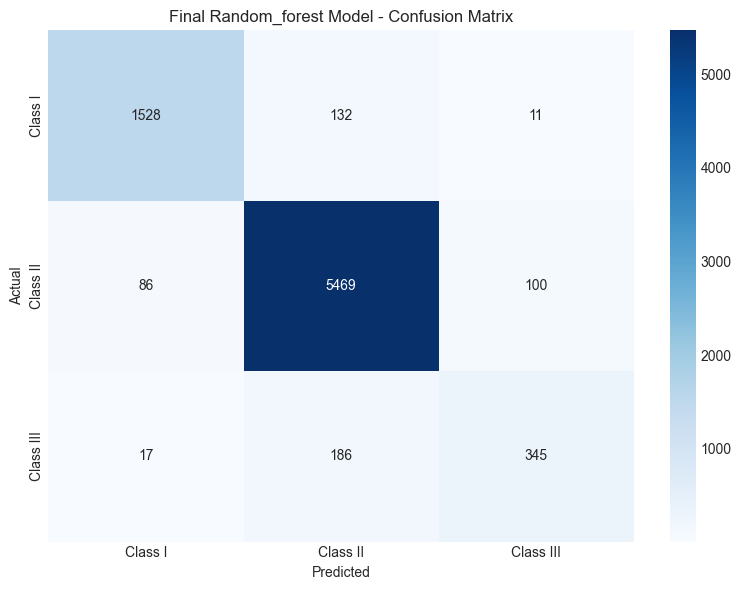

In [41]:
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f"Final {best_model_name.capitalize()} Model - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f'results/{dataset_type}/final_model_confusion_matrix.png', dpi=300)
plt.show()
plt.close()

#### Evaluation Metrics

In [42]:
# Calculate metrics
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

print(f"\nFinal Model Test Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Final Model Test Metrics:
Accuracy: 0.9324
Precision: 0.9302
Recall: 0.9324
F1 Score: 0.9308


#### Class-specific Metrics

In [43]:
# Loop through each class in target variable and compute Precision, Recall, F1 score
for i, class_name in enumerate(class_names):
    class_precision = precision_score(y_test_encoded, y_pred, labels=[i], average=None)[0]
    class_recall = recall_score(y_test_encoded, y_pred, labels=[i], average=None)[0]
    class_f1 = f1_score(y_test_encoded, y_pred, labels=[i], average=None)[0]
    
    print(f"{class_name}:")
    print(f"  Precision: {class_precision:.4f}")
    print(f"  Recall: {class_recall:.4f}")
    print(f"  F1 Score: {class_f1:.4f}")

Class I:
  Precision: 0.9368
  Recall: 0.9144
  F1 Score: 0.9255
Class II:
  Precision: 0.9450
  Recall: 0.9671
  F1 Score: 0.9560
Class III:
  Precision: 0.7566
  Recall: 0.6296
  F1 Score: 0.6873


#### ROC Curves

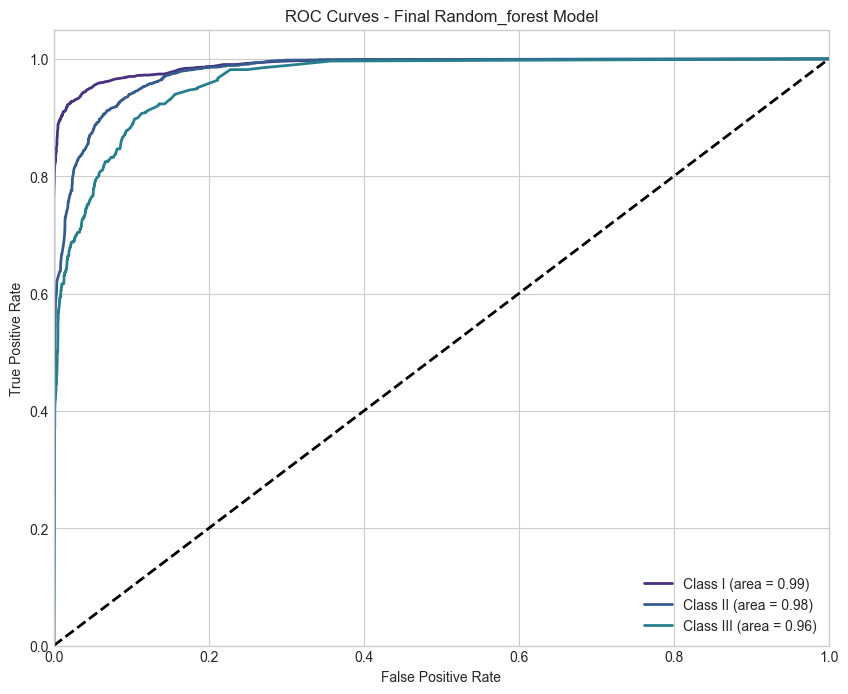

In [44]:
# If model supports predict_proba, then get predicted variable for each class
if hasattr(final_pipeline, 'predict_proba'):
    y_proba = final_pipeline.predict_proba(X_test)
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    
    # For each class
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_test_encoded == i, y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (area = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - Final {best_model_name.capitalize()} Model')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(f'results/{dataset_type}/final_model_roc_curves.png', dpi=300)
    plt.show()
    plt.close()

## Random Forest Hyperparameter Analysis: Number of Trees vs OOB Error

Observe model's Out-of-Bag (OOB) error changes with the number of trees and different feature selection strategies

In [45]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

# This code was drieved from --> https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html 

# Define ensemble configurations
ensemble_clfs = [
    (
        "RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features="sqrt",
            random_state=42,
            bootstrap=True  # Required for OOB
        ),
    ),
    (
        "RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features="log2",
            random_state=42,
            bootstrap=True
        ),
    ),
    (
        "RandomForestClassifier, max_features=None",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features=None,
            random_state=42,
            bootstrap=True
        ),
    ),
]

In [46]:
# Dictionary to store error rates
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

In [47]:
# Range of n_estimators to evaluate
min_estimators = 15
max_estimators = 150

In [48]:
# Loop over models and number of estimators
for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X_train_resampled, y_train_resampled)
        
        # Track the OOB error
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

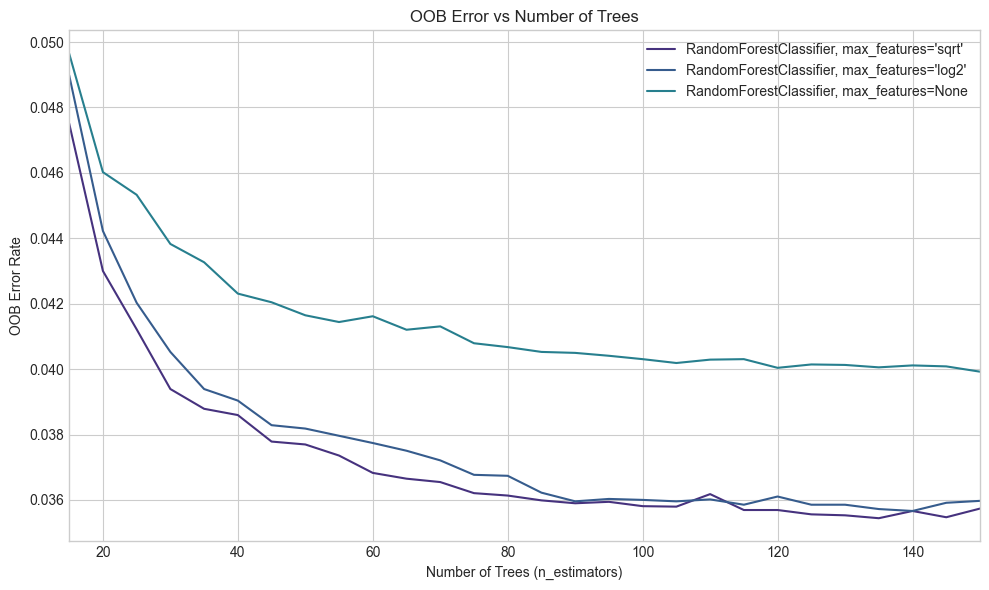

In [49]:
# Plot the OOB error vs. number of trees
plt.figure(figsize=(10, 6))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("OOB Error Rate")
plt.title("OOB Error vs Number of Trees")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig(f'results/{dataset_type}/rf_oob_error_vs_trees.png', dpi=300)
plt.show()
plt.close()

## Feature Importance Analysis


Top 10 most important features:
                   Feature  Importance
         Reason_Word_Count    0.137025
                 Month_sin    0.078960
                 Month_cos    0.073709
ProductType_Food/Cosmetics    0.067659
         Years_Since_First    0.067499
             DayOfWeek_sin    0.057949
       ProductType_Devices    0.051590
             DayOfWeek_cos    0.046227
              has_listeria    0.040448
           DistScope_Other    0.038624


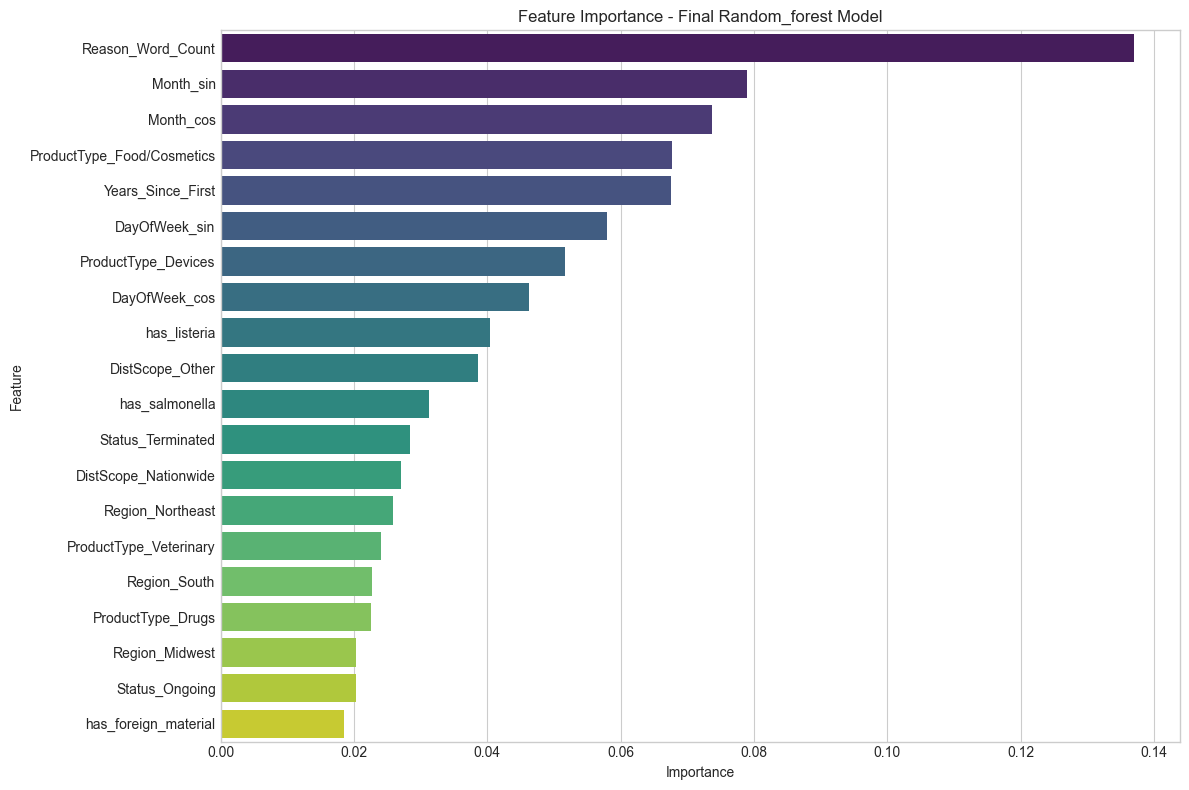

In [50]:
# Used ChatGPT to streamline the analysis and visualization of feature importance
if hasattr(final_pipeline.named_steps['model'], 'feature_importances_'):
    # For tree-based models that have feature_importances_
    if 'feature_selection' in final_pipeline.named_steps:
        # Get selected features
        mask = final_pipeline.named_steps['feature_selection'].get_support()
        selected_features = X_train.columns[mask]
        importances = final_pipeline.named_steps['model'].feature_importances_
        
        # Create DataFrame for visualization
        importance_df = pd.DataFrame({
            'Feature': selected_features,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
    else:
        # All features were used
        importances = final_pipeline.named_steps['model'].feature_importances_
        importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 most important features:")
    print(importance_df.head(10).to_string(index=False))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
    plt.title(f"Feature Importance - Final {best_model_name.capitalize()} Model")
    plt.tight_layout()
    plt.savefig(f'results/{dataset_type}/final_model_feature_importance.png', dpi=300)
    plt.show()
    plt.close()
    
    # Save feature importance to CSV
    importance_df.to_csv(f'results/{dataset_type}/final_model_feature_importance.csv', index=False)
elif hasattr(final_pipeline.named_steps['model'], 'coef_'):
    # For models like Logistic Regression that have coefficients
    if 'feature_selection' in final_pipeline.named_steps:
        # Get selected features
        mask = final_pipeline.named_steps['feature_selection'].get_support()
        selected_features = X_train.columns[mask]
        
        # For multi-class, take mean absolute coefficient values
        coef = final_pipeline.named_steps['model'].coef_
        if coef.ndim > 1:
            importances = np.mean(np.abs(coef), axis=0)
        else:
            importances = np.abs(coef)
        
        # Create DataFrame for visualization
        importance_df = pd.DataFrame({
            'Feature': selected_features,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
    else:
        # All features were used
        coef = final_pipeline.named_steps['model'].coef_
        if coef.ndim > 1:
            importances = np.mean(np.abs(coef), axis=0)
        else:
            importances = np.abs(coef)
        
        importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 most important features:")
    print(importance_df.head(10).to_string(index=False))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
    plt.title(f"Feature Importance - Final {best_model_name.capitalize()} Model")
    plt.tight_layout()
    plt.savefig(f'results/{dataset_type}/final_model_feature_importance.png', dpi=300)
    plt.show()
    plt.close()
    
    # Save feature importance to CSV
    importance_df.to_csv(f'results/{dataset_type}/final_model_feature_importance.csv', index=False)
else:
    # Use the CV feature importance tracking
    print("\nFeature importance based on selection frequency during CV:")
    
    # Normalize by model count
    avg_importance = feature_importance.mean(axis=1)
    importance_df = pd.DataFrame({
        'Feature': feature_importance.index,
        'Selection Frequency': avg_importance
    }).sort_values('Selection Frequency', ascending=False)
    
    print(importance_df.head(10).to_string(index=False))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Selection Frequency', y='Feature', data=importance_df.head(20), palette='viridis')
    plt.title("Feature Selection Frequency Across Models")
    plt.tight_layout()
    plt.savefig(f'results/{dataset_type}/feature_selection_frequency.png', dpi=300)
    plt.show()
    plt.close()
    
    # Save feature importance to CSV
    importance_df.to_csv(f'results/{dataset_type}/feature_selection_frequency.csv', index=False)

#### Model Comparison

In [51]:
# Train individual models with their best configurations from CV
models_to_compare = {}

In [52]:
# For each model, train using its best configuration from CV
for model_name, model_config in best_configs.items():
    
    # Define steps for the pipeline
    steps = []
    
    # Add scaling if needed
    if models[model_name]['needs_scaling']:
        steps.append(('scaler', StandardScaler()))
    
    # Add feature selection unless n_features is 'all'
    if model_config['config']['n_features'] != 'all':
        if models[model_name]['feature_selector'] == SelectKBest:
            steps.append(('feature_selection', 
                          SelectKBest(f_classif, k=model_config['config']['n_features'])))
        else:
            steps.append(('feature_selection', 
                          models[model_name]['feature_selector'](models[model_name]['model'], 
                                                                max_features=model_config['config']['n_features'])))
    
    # Add the model with best parameters
    # Extract model parameters
    best_params = {k.replace('model__', ''): v for k, v in model_config['config']['parameters'].items()}
    model_instance = models[model_name]['model'].__class__(**best_params, random_state=42)
    steps.append(('model', model_instance))
    
    # Set random state for any components in pipeline that might use randomness
    for name, step in steps:
        if hasattr(step, 'random_state'):
            setattr(step, 'random_state', 42)
    
    # Create and train pipeline
    pipeline = Pipeline(steps)
    np.random.seed(42)
    pipeline.fit(X_train_resampled, y_train_resampled)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Store pipeline and predictions
    models_to_compare[model_name] = {
        'pipeline': pipeline,
        'pred': y_pred
    }
    
    # Save model
    joblib.dump(pipeline, f'results/{dataset_type}/final_models/{model_name}_final_model.joblib')

#### Collect all metrics for comparison

In [53]:
# Calculate metrics for each model
for name, model_dict in models_to_compare.items():
    preds = model_dict['pred']
    model_dict['accuracy'] = accuracy_score(y_test_encoded, preds)
    model_dict['precision'] = precision_score(y_test_encoded, preds, average='weighted')
    model_dict['recall'] = recall_score(y_test_encoded, preds, average='weighted')
    model_dict['f1'] = f1_score(y_test_encoded, preds, average='weighted')
    
    # Class-specific metrics
    model_dict['class_reports'] = classification_report(y_test_encoded, preds, 
                                                     target_names=class_names, 
                                                     output_dict=True)

In [54]:
# Create comparison DataFrame
metrics_df = pd.DataFrame({
    'Model': list(models_to_compare.keys()),
    'Accuracy': [model_dict['accuracy'] for model_dict in models_to_compare.values()],
    'Precision': [model_dict['precision'] for model_dict in models_to_compare.values()],
    'Recall': [model_dict['recall'] for model_dict in models_to_compare.values()],
    'F1 Score': [model_dict['f1'] for model_dict in models_to_compare.values()]
})

In [55]:
# Sort by F1 Score
metrics_df = metrics_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)

In [56]:
# Display the comparison
print("\nModel Performance Comparison:")
print(metrics_df.to_string(index=False, float_format='%.4f'))


Model Performance Comparison:
        Model  Accuracy  Precision  Recall  F1 Score
random_forest    0.9324     0.9302  0.9324    0.9308
decision_tree    0.9106     0.9122  0.9106    0.9113
          mlp    0.8799     0.8951  0.8799    0.8855
      xgboost    0.8759     0.8790  0.8759    0.8772
       logreg    0.6562     0.7711  0.6562    0.6931


In [57]:
# Save to CSV
metrics_df.to_csv(f'results/{dataset_type}/model_comparison.csv', index=False)

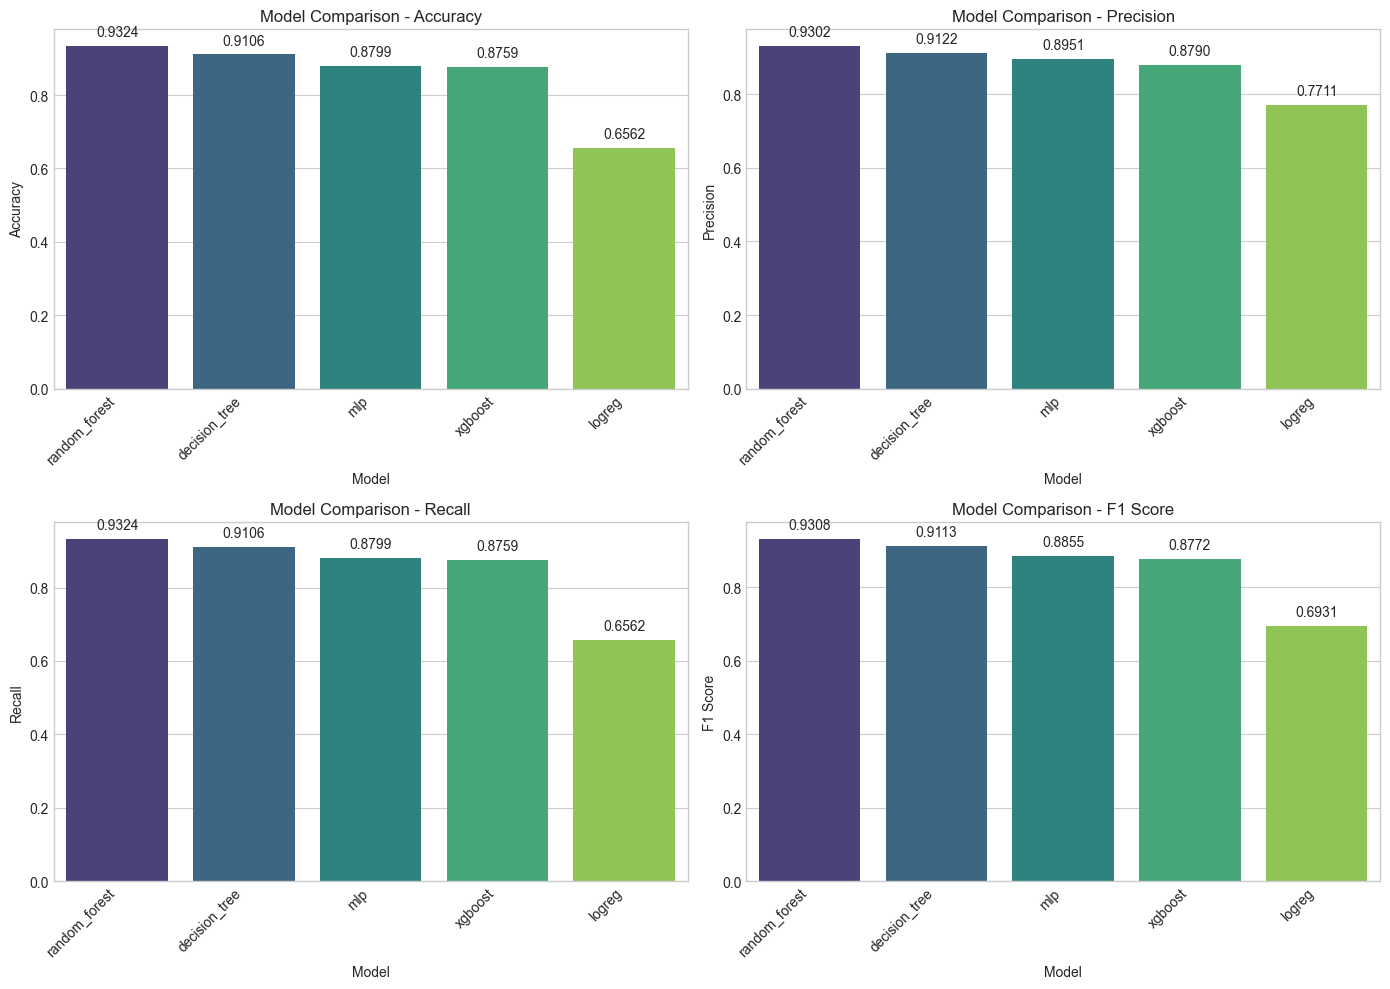

In [58]:
# Visualize the comparison
plt.figure(figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plot each metric
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')
    plt.title(f'Model Comparison - {metric}')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels to bars
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom', 
                   xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()
plt.savefig(f'results/{dataset_type}/model_metrics_comparison.png', dpi=300)
plt.show()
plt.close()

In [59]:
# Generate detailed class-specific comparison
class_metrics = {}
for class_idx, class_name in enumerate(class_names):
    class_metrics[class_name] = {
        'Model': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': []
    }
    
    for model_name, model_dict in models_to_compare.items():
        class_report = model_dict['class_reports'][class_name]
        class_metrics[class_name]['Model'].append(model_name)
        class_metrics[class_name]['Precision'].append(class_report['precision'])
        class_metrics[class_name]['Recall'].append(class_report['recall'])
        class_metrics[class_name]['F1 Score'].append(class_report['f1-score'])

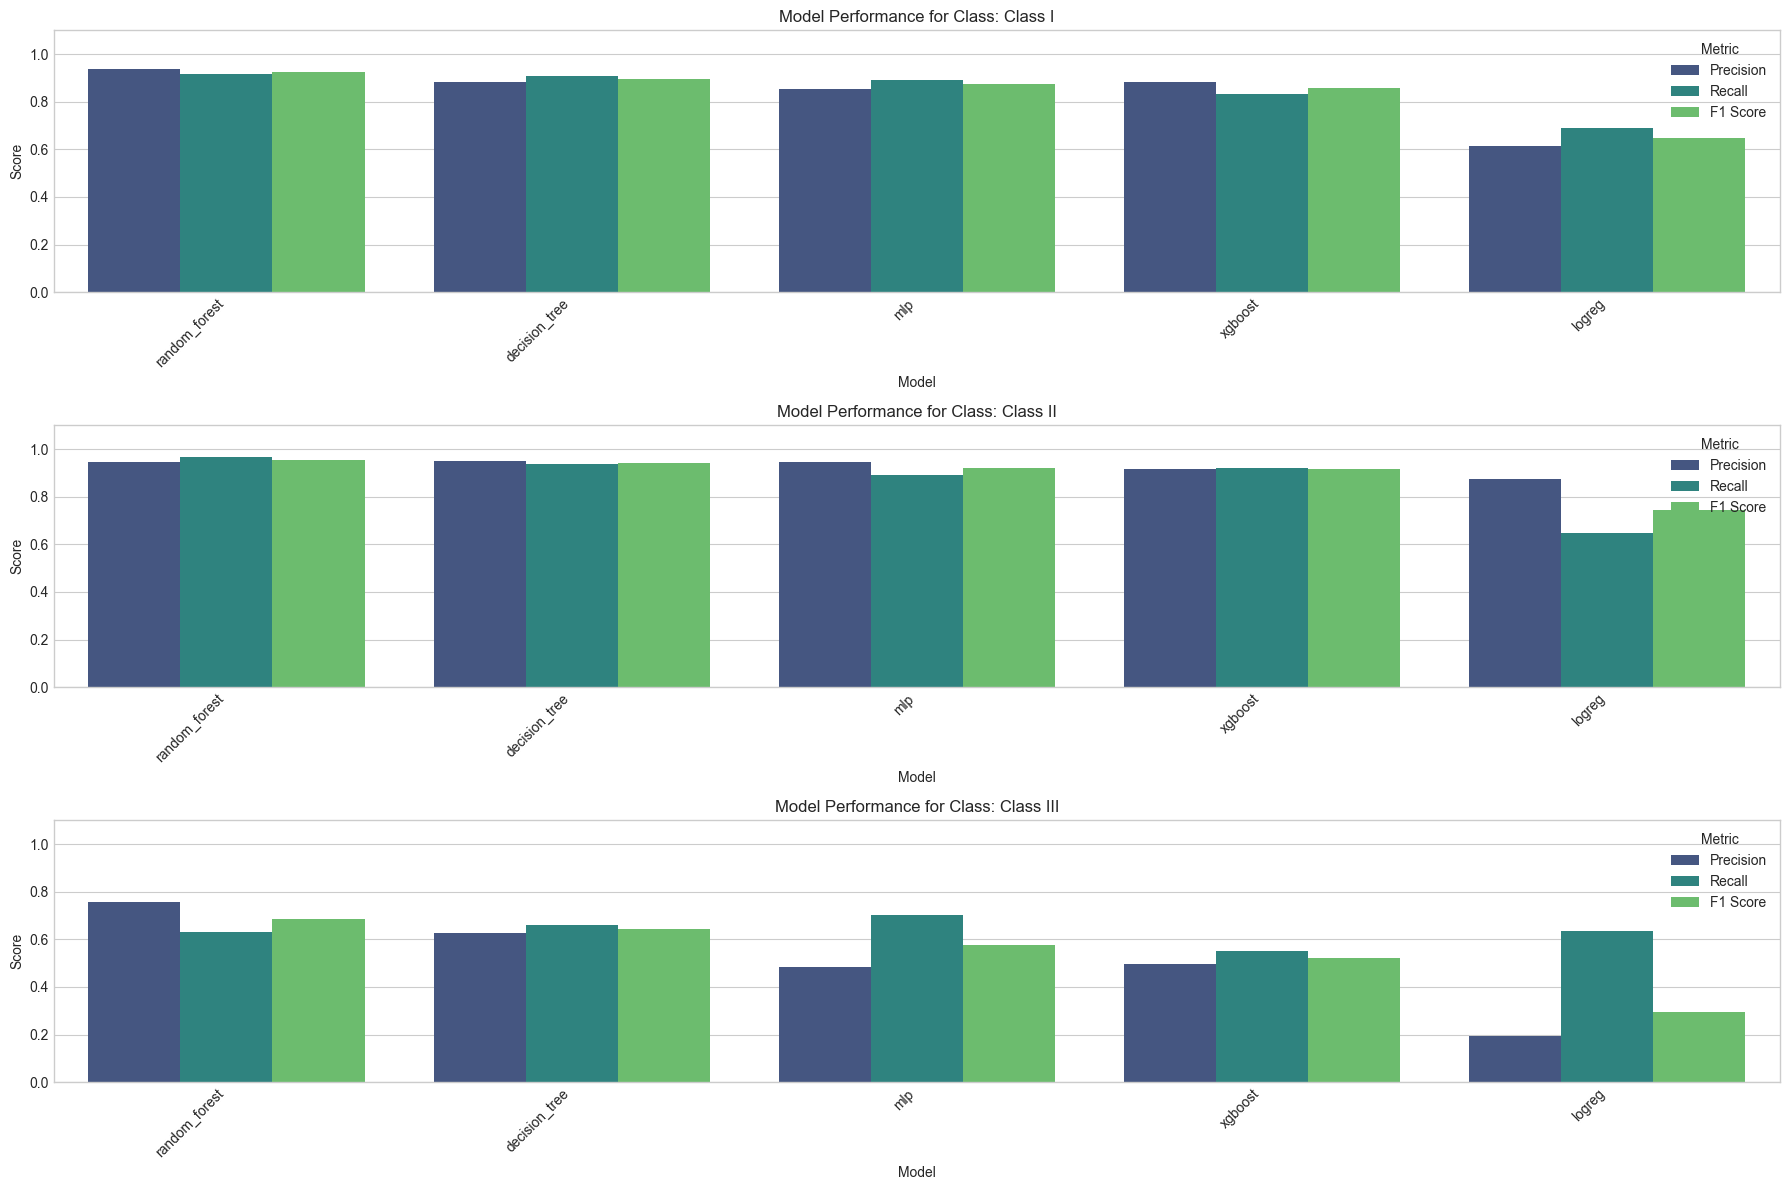

In [60]:
# Plot class-specific performance for each model
plt.figure(figsize=(18, 12))
for i, class_name in enumerate(class_names):
    # Create DataFrame for this class
    df = pd.DataFrame(class_metrics[class_name])
    df = df.sort_values('F1 Score', ascending=False)
    
    plt.subplot(len(class_names), 1, i+1)
    
    # Melt the DataFrame for easier plotting
    df_melted = pd.melt(df, id_vars=['Model'], value_vars=['Precision', 'Recall', 'F1 Score'],
                        var_name='Metric', value_name='Value')
    
    # Plot grouped bar chart
    sns.barplot(x='Model', y='Value', hue='Metric', data=df_melted, palette='viridis')
    
    plt.title(f'Model Performance for Class: {class_name}')
    plt.ylabel('Score')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.1)
    plt.legend(title='Metric')

plt.tight_layout()
plt.savefig(f'results/{dataset_type}/class_specific_performance.png', dpi=300)
plt.show()
plt.close()

In [61]:
# Save class-specific metrics to CSV
for class_name, metrics in class_metrics.items():
    pd.DataFrame(metrics).to_csv(f'results/{dataset_type}/metrics_{class_name.replace(" ", "_")}.csv', index=False)

# Summary and Conclusions

#### Class-specific test performance

In [62]:
# Create class-specific performance DataFrame
class_report = classification_report(y_test_encoded, y_pred, target_names=class_names, output_dict=True)
class_df = pd.DataFrame()

for class_name in class_names:
    class_df.loc[class_name, 'f1-score'] = class_report[class_name]['f1-score']
    class_df.loc[class_name, 'precision'] = class_report[class_name]['precision']
    class_df.loc[class_name, 'recall'] = class_report[class_name]['recall']

class_df = class_df.sort_values('f1-score', ascending=False)
print(class_df)

           f1-score  precision    recall
Class II   0.919381   0.946954  0.893369
Class I    0.872695   0.853952  0.892280
Class III  0.574198   0.485498  0.702555


#### Best and Worst Performing Classes

In [63]:
# Select first (best) and last (worst) index
best_class = class_df.index[0]
worst_class = class_df.index[-1]

print(f"\nBest performing class: {best_class} (F1: {class_df.loc[best_class, 'f1-score']:.4f})")
print(f"Worst performing class: {worst_class} (F1: {class_df.loc[worst_class, 'f1-score']:.4f})")


Best performing class: Class II (F1: 0.9194)
Worst performing class: Class III (F1: 0.5742)


#### Save Summary into JSON file

In [64]:
# Summary dictionary
summary = {
    'dataset_type': dataset_type,
    'best_model': best_model_name,
    'best_cv_f1': float(best_model_score),
    'test_f1': float(f1),
    'best_class': best_class,
    'best_class_f1': float(class_df.loc[best_class, 'f1-score']),
    'worst_class': worst_class,
    'worst_class_f1': float(class_df.loc[worst_class, 'f1-score']),
    'best_features': best_model_features[:10] if best_model_features else None,
    'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
}

with open(f'results/{dataset_type}/modeling_summary.json', 'w') as f:
    json.dump(summary, f, indent=4)

In [65]:
print(f"\nModeling process completed for {dataset_type} dataset.")
print(f"Best model: {best_model_name}")
print(f"Best CV F1 Score: {best_model_score:.4f}")
print(f"Test F1 Score: {f1:.4f}")

if best_model_features:
    print(f"Top 5 most important features: {', '.join(best_model_features[:5])}")


Modeling process completed for baseline dataset.
Best model: random_forest
Best CV F1 Score: 0.9215
Test F1 Score: 0.9308
Top 5 most important features: Month_sin, Month_cos, DayOfWeek_sin, DayOfWeek_cos, Years_Since_First
